In [1]:
import gensim
import math
import nltk
import numpy as np
import operator
import pandas as pd
import pickle
import pydotplus
import random
import re
import seaborn as sns
import string
import sys
import time
import warnings
import zipfile

from collections import Counter

from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.lsimodel import LsiModel

from gensim.utils import simple_preprocess
from gensim.utils import simple_preprocess

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from io import StringIO

from IPython.display import Image

from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import ticker

from mlxtend.classifier import StackingClassifier

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.stem.wordnet import WordNetLemmatizer

from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim

from scipy import stats
from scipy.cluster import hierarchy as sch

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_moons
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support as error_metric
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from string import punctuation

from textblob import TextBlob

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud
from wordcloud import STOPWORDS

from xgboost import XGBClassifier
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

In [2]:
def plot_auc(y_test, y_pred):
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def get_results_df(gscv_model,):
    # Creating a dictionary out of the GridSearchCV results
    results_dict = {}
    results = gscv_model.cv_results_
    
    for key in results.keys():
        if type(results[key]) == np.ndarray:
            results_dict[key] = list(results[key])
            
        elif type(results[key]) == np.ma.core.MaskedArray:
            results_dict[key] = list(results[key])
            
        elif type(results[key]) == list:
            pass
        else:
            print("Unkown type encountered")
        
    return_df = pd.DataFrame(data=results_dict,)
    
    if return_df.isnull().sum().max() > 0:
        print("Incorrect model training values have been omitted")
        print("{0} values".format(return_df.isnull().sum().max()))
    return_df.dropna(axis=0, inplace=True)
    
    return return_df

def get_scores(model, X_test, y_test,):
    y_pred = model.best_estimator_.predict(X_test,)
    print("Accuracy: {0}".format(accuracy_score(y_test, y_pred,)))
    print("\n")
    print("Recall: {0}".format(recall_score(y_test, y_pred,)))
    print("Precision: {0}".format(precision_score(y_test, y_pred,)))
    print("F1 Score: {0}".format(f1_score(y_test, y_pred,)))
    print("\n")
    print("ROC AUC: {0}".format(roc_auc_score(y_test, y_pred,)))
    print("\n")
    print("Confusion Matrix: \n{0}".format(confusion_matrix(y_test, y_pred,)))
    print("\n")
    print("Classification Report: \n{0}".format(classification_report(y_test, y_pred,)))
    plot_auc(y_test, y_pred)
    
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [3]:
data = pd.read_csv('processed data/data_for_training.csv', index_col=0)

In [4]:
test_set = data[ data['Survived'].isnull() ].copy()
test_set.drop(columns=['Survived'], axis=1, inplace=True)

In [5]:
train_set = data[ data['Survived'].notnull() ].copy()

## Training Pipeline

In [6]:
X, y = train_set.drop('Survived', axis=1, inplace=False), train_set['Survived'].copy()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   stratify=y, random_state=4)

In [8]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

### Logistic Regression

In [9]:
# file_name = 'trained models/lr1.pickle'

# hyperparameters = {
#     'penalty': ['l1', 'l2', 'elasticnet', 'None'],
#     'C': [0.05, 0.25, 0.7, 1, 2,],
#     'class_weight': ['balanced', {0:1, 1:5,}],
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'max_iter':[1000, 5000,],
#     'n_jobs': [-1],
#     'l1_ratio': [0.25, 0.4, 0.5, 0.6, 0.75,],
# }

# scoring = "roc_auc"

# model = GridSearchCV(LogisticRegression(random_state=44), hyperparameters, cv=10, 
#                      verbose=1, scoring=scoring, 
#                      n_jobs=-1, return_train_score=True)

# try:
#     with open(file_name, 'rb') as handle:
#         model = pickle.load(handle)
#     print("Found trained model file with same name. Loading it instead.")
    
# except:
#     start_time = time.time()

#     model.fit(X_train, y_train,)

#     time_taken_s = np.around(time.time()-start_time, decimals=2,)
#     time_taken_m = time_taken_s/60  
#     print('Total Time taken = {0} seconds \nIn minutes: {1}'.format(time_taken_s, time_taken_m,))

#     with open(file_name, 'wb') as handle:
#         pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
# get_results_df(model)

In [11]:
# get_scores(model, X_test, y_test,)

In [12]:
# results = pd.Series(model.best_estimator_.predict(test_set)).to_frame()

In [13]:
# results = pd.DataFrame({
#     'PassengerId': test_set.index,
#     'Survived': model.best_estimator_.predict(test_set)})
# results.to_csv('lr1.csv', index=False)

# Other Pipeline

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

In [15]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [16]:
# Modeling step Test differents algorithms 
random_state = 44
classifiers = []

classifiers.append( LogisticRegression( random_state = random_state))
classifiers.append( DecisionTreeClassifier( random_state = random_state))
classifiers.append( RandomForestClassifier( random_state = random_state))
classifiers.append( ExtraTreesClassifier( random_state = random_state))
classifiers.append( KNeighborsClassifier())
classifiers.append( SVC( random_state = random_state))
classifiers.append( AdaBoostClassifier( DecisionTreeClassifier( random_state= random_state), 
                                       random_state = random_state, learning_rate=0.1))
classifiers.append( GradientBoostingClassifier( random_state = random_state))
classifiers.append( MLPClassifier( random_state = random_state))
classifiers.append( LinearDiscriminantAnalysis())
classifiers.append( XGBClassifier( random_state = random_state))

In [17]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y=y_train, 
                                      scoring="roc_auc", cv=kfold, 
                                      n_jobs=4))

In [18]:
cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans": cv_means,
                       "CrossValerrors": cv_std,
                       "Algorithm":["LogisticRegression",
                                    "DecisionTree",
                                    "RandomForest",
                                    "ExtraTrees",
                                    "KNeighboors",
                                    "SVC",
                                    "AdaBoost",
                                    "GradientBoosting",
                                    "MultipleLayerPerceptron",
                                    "LinearDiscriminantAnalysis",
                                    "XGBClassifier"],
                      })

# cv_res = cv_res.sort_values(by='CrossValMeans')
# cv_res = cv_res.sort_values(by='CrossValerrors')

In [19]:
cv_res['CrossValerrors'].sort_values()

0     0.033479
4     0.034111
8     0.038027
2     0.038119
7     0.038771
9     0.038972
10    0.042068
1     0.042770
5     0.043548
3     0.046763
6     0.055189
Name: CrossValerrors, dtype: float64

Text(0.5, 0, 'Mean AUROC Curve')

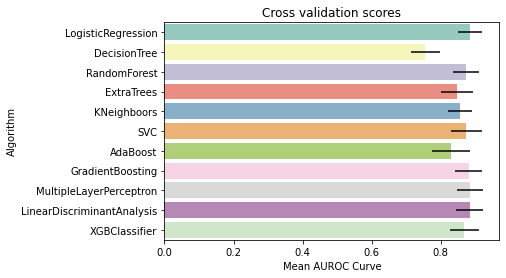

In [20]:
figure = sns.barplot("CrossValMeans", "Algorithm", data=cv_res, palette="Set3", 
                orient="h", **{'xerr':cv_std})
figure.set_xlabel("Mean AUROC Curve")
figure = figure.set_title("Cross validation scores")

#### Choosing the following models due to their consistency and high accuracy/low error
* 2 Random Forest
* 3 Extra Trees
* 5 SVC
* 7 Gradient Boosting
* 8 Multi Layer Perceptron

In [21]:
trained_models = {}

#### Random Forest

In [22]:
scoring_ = "roc_auc"

file_name = "trained models/random_forest_1.pickle"

model = RandomForestClassifier( random_state = 44 )

hyperparameters = {"max_depth": [None],
                   "max_features": [1, 3, 10],
                   "min_samples_split": [2, 3, 10],
                   "min_samples_leaf": [1, 3, 10],
                   "bootstrap": [False],
                   "n_estimators": [100, 300],
                   "criterion": ["gini"],
                  }

gscv_model = GridSearchCV(model, param_grid=hyperparameters, 
                          cv=10, scoring=scoring_, 
                          n_jobs=-1, verbose=1,
                          return_train_score=True)

try:
    with open(file_name, 'rb') as handle:
        gscv_model = pickle.load(handle)
    print("Found trained model file with same name. Loading it instead.")
    
except:
    gscv_model.fit(X_train, y_train)
    with open(file_name, 'wb') as handle:
        pickle.dump(gscv_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
trained_models[f'{file_name}'] = (scoring_, hyperparameters, gscv_model.best_estimator_)

Found trained model file with same name. Loading it instead.


#### Extra Trees

In [23]:
scoring_ = "roc_auc"

file_name = "trained models/extra_trees_1.pickle"

model = ExtraTreesClassifier( random_state = 44 )

hyperparameters = {"max_depth": [None],
                   "max_features": [1, 3, 10],
                   "min_samples_split": [2, 3, 10],
                   "min_samples_leaf": [1, 3, 10],
                   "bootstrap": [False],
                   "n_estimators": [100, 300],
                   "criterion": ["gini"],
                  }

gscv_model = GridSearchCV(model, param_grid=hyperparameters, 
                          cv=10, scoring=scoring_, 
                          n_jobs=-1, verbose=1,
                          return_train_score=True)

try:
    with open(file_name, 'rb') as handle:
        gscv_model = pickle.load(handle)
    print("Found trained model file with same name. Loading it instead.")
    
except:
    gscv_model.fit(X_train, y_train)
    with open(file_name, 'wb') as handle:
        pickle.dump(gscv_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
trained_models[f'{file_name}'] = (scoring_, hyperparameters, gscv_model.best_estimator_)

Found trained model file with same name. Loading it instead.


#### SVC

In [24]:
scoring_ = "roc_auc"

file_name = "trained models/svc_2.pickle"

model = SVC( random_state = 44, probability=True)

hyperparameters = {'kernel': ['rbf'], 
                  'gamma': [0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100, 200, 300, 1000],
                  }

gscv_model = GridSearchCV(model, param_grid=hyperparameters, 
                          cv=10, scoring=scoring_, 
                          n_jobs=-1, verbose=1,
                          return_train_score=True)

try:
    with open(file_name, 'rb') as handle:
        gscv_model = pickle.load(handle)
    print("Found trained model file with same name. Loading it instead.")
    
except:
    gscv_model.fit(X_train, y_train)
    with open(file_name, 'wb') as handle:
        pickle.dump(gscv_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
trained_models[f'{file_name}'] = (scoring_, hyperparameters, gscv_model.best_estimator_)

Found trained model file with same name. Loading it instead.


#### Gradient Boosting

In [25]:
scoring_ = "roc_auc"

file_name = "trained models/gb_1.pickle"

model = GradientBoostingClassifier( random_state = 44 )

hyperparameters = {'loss': ['deviance'],
                   'n_estimators': [100, 200, 300],
                   'learning_rate': [0.1, 0.05, 0.01],
                   'max_depth': [4, 8],
                   'min_samples_leaf': [100, 150],
                   'max_features': [0.3, 0.1],
                  }

gscv_model = GridSearchCV(model, param_grid=hyperparameters, 
                          cv=10, scoring=scoring_, 
                          n_jobs=-1, verbose=1,
                          return_train_score=True)

try:
    with open(file_name, 'rb') as handle:
        gscv_model = pickle.load(handle)
    print("Found trained model file with same name. Loading it instead.")
    
except:
    gscv_model.fit(X_train, y_train)
    with open(file_name, 'wb') as handle:
        pickle.dump(gscv_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
trained_models[f'{file_name}'] = (scoring_, hyperparameters, gscv_model.best_estimator_)

Found trained model file with same name. Loading it instead.


#### Multi Layer Perceptron

In [26]:
scoring_ = "roc_auc"

file_name = "trained models/ml_perceptron_1.pickle"

model = MLPClassifier( random_state = 44 )

hyperparameters = {'hidden_layer_sizes': [2, 10, 25, 50, 100, 200],
                   'activation': ['identity'],
                   'solver': ['lbfgs'],
                   'alpha': [0.01, 0.001, 0.0001, 0.0005],
                   'learning_rate_init': [0.001, 0.01, 0.0001],
                   'max_iter': [200, 500],
                   'verbose': [True],
                  }

gscv_model = GridSearchCV(model, param_grid=hyperparameters, 
                          cv=10, scoring=scoring_, 
                          n_jobs=-1, verbose=1,
                          return_train_score=True)

try:
    with open(file_name, 'rb') as handle:
        gscv_model = pickle.load(handle)
    print("Found trained model file with same name. Loading it instead.")
    
except:
    gscv_model.fit(X_train, y_train)
    with open(file_name, 'wb') as handle:
        pickle.dump(gscv_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
trained_models[f'{file_name}'] = (scoring_, hyperparameters, gscv_model.best_estimator_)

Found trained model file with same name. Loading it instead.


#### Learning curves

Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

In [2]:
for key in trained_models:
    figure = plot_learning_curve(trained_models[key][2], key,
                                 X_train, y_train, cv=10)

NameError: name 'trained_models' is not defined

#### Feature importance using tree based classifiers

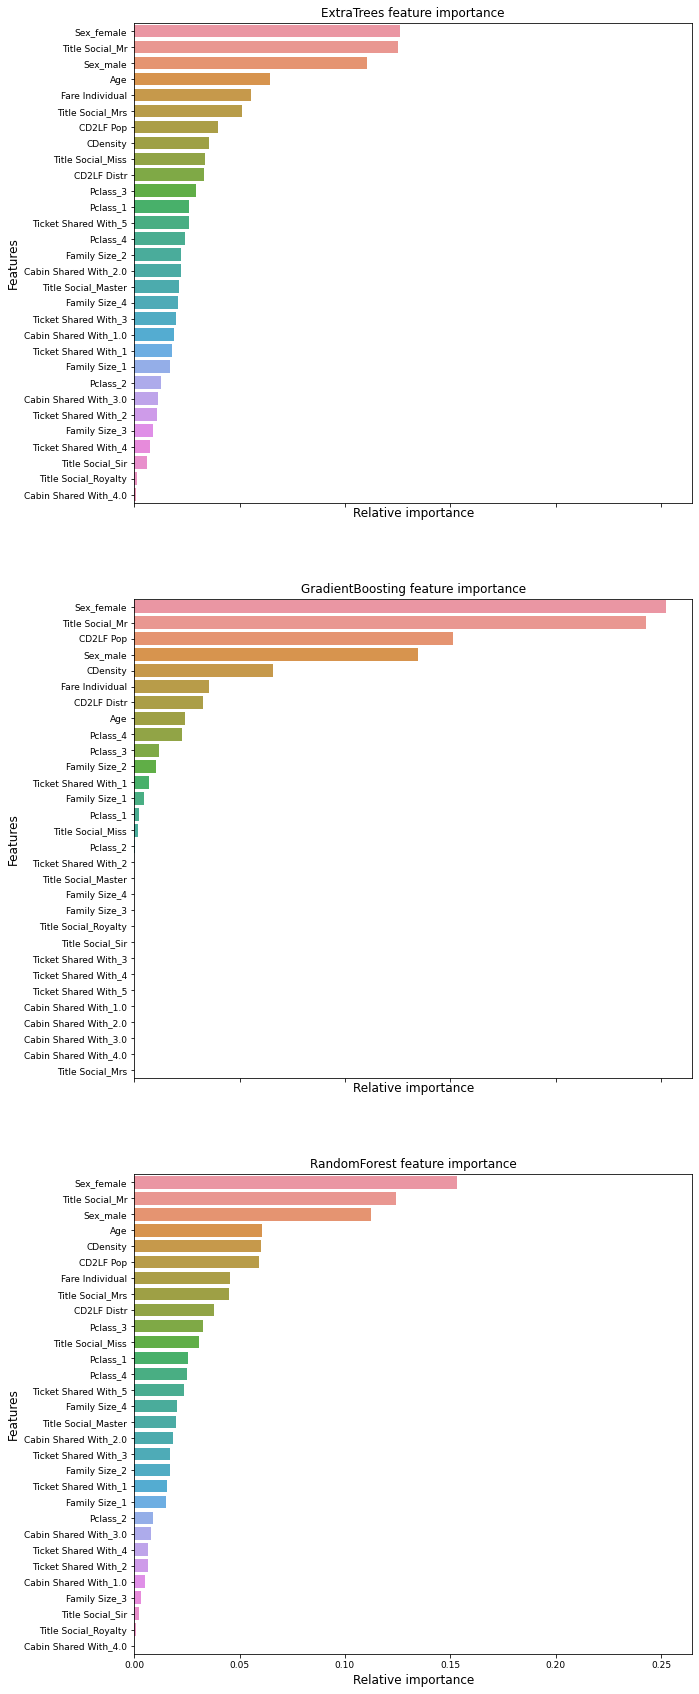

In [28]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, sharex="all", figsize=(10, 30))

names_classifiers = [("ExtraTrees", trained_models["trained models/extra_trees_1.pickle"][2]),
                     ("GradientBoosting", trained_models["trained models/gb_1.pickle"][2]),
                     ("RandomForest", trained_models["trained models/random_forest_1.pickle"][2])]

for row in range(0, 3):
    name = names_classifiers[row][0]
    classifier = names_classifiers[row][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    
    figure = sns.barplot(x = classifier.feature_importances_[indices][:40],
                         y = X_train.columns[indices][:40],
                         orient='h', ax=axes[row])
    _ = figure.set_xlabel("Relative importance", fontsize=12)
    _ = figure.set_ylabel("Features", fontsize=12)
    _ = figure.tick_params(labelsize=9)
    _ = figure.set_title(name + " feature importance")

#### Collinearity among classifiers

In [29]:
test_set

,Age,Fare Individual,CDensity,CD2LF Pop,CD2LF Distr,Pclass_1,Pclass_2,Pclass_3,Pclass_4,Sex_female,...,Ticket Shared With_4,Ticket Shared With_5,Cabin Shared With_1.0,Cabin Shared With_2.0,Cabin Shared With_3.0,Cabin Shared With_4.0,Family Size_1,Family Size_2,Family Size_3,Family Size_4
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,16.051605,2.857390,3.100000,2.980769,1.953125,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
893,20.604838,2.651764,2.373239,2.553812,2.178697,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
894,25.431894,3.268326,1.709877,2.193922,1.683063,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
895,13.396400,3.048341,3.100000,2.980769,1.953125,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
896,11.378487,2.419911,2.373239,2.553812,2.178697,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,16.417590,2.909327,3.100000,2.980769,1.953125,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1306,17.852984,6.502459,0.776442,1.058785,2.704327,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
1307,17.498220,2.715410,3.100000,2.980769,1.953125,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


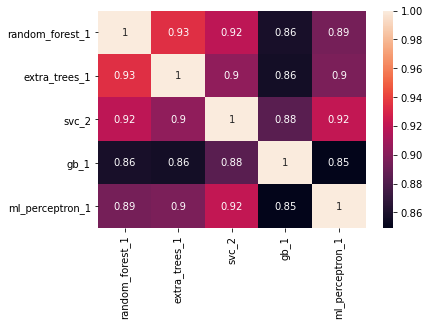

In [30]:
y_pred = {}

for key in trained_models:
    y_pred[key] = pd.Series(trained_models[key][2].predict(test_set),
                           name=key.split('/')[1].split('.')[0])

# Concatenate all classifier results
ensemble_results = pd.concat([y_pred[key] for key in y_pred],
                             axis=1)

figure = sns.heatmap(ensemble_results.corr(), annot=True)

#### Ensemble Method

I choosed a voting classifier to combine the predictions coming from the 5 classifiers.
I preferred to pass the argument "soft" to the voting parameter to take into account the probability of each vote.

* 2 Random Forest
* 3 Extra Trees
* 5 SVC
* 7 Gradient Boosting
* 8 Multi Layer Perceptron

In [31]:
voting_model = VotingClassifier(estimators=[ (key.split('/')[1].split('.')[0],
                                             trained_models[key][2])
                                             for key in trained_models ], 
                                voting='soft', n_jobs=4)

voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_1',
                              RandomForestClassifier(bootstrap=False,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=3,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=3,
                                                     min_samples_split=10,
                                                     min_weight_fraction_leaf=0.0

#### Final Prediction

In [32]:
test_set.reset_index()['PassengerId']

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [36]:
y_pred_final = pd.Series(voting_model.predict(test_set), name="Survived")

index_series = data[ data['Survived'].isnull() ].index

results = pd.concat([test_set.reset_index()['PassengerId'], y_pred_final], 
                    axis=1)

results.to_csv("final_prediction.csv", index=False)